In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('../../hces-2023-24/data/sec-1-HCQ.parquet')  # , usecols=['sector', 'state_name', 'district_name'])
df = df[['sector', 'nss_region']]
df.head()

,sector,nss_region
hhid,,
46667201,rural,12
46667301,rural,12
46667302,rural,12
46667303,rural,12
46667304,rural,12


In [3]:
xdf = pd.read_parquet('../../hces-2023-24/data/sec-4-HCQ.parquet')
xdf = xdf[['hh_size', 'max_income_from', 'hoh_religion', 'caste']]
xdf.head()

,hh_size,max_income_from,hoh_religion,caste
hhid,,,,
22300101,4,self-employment,Hinduism,other backward class (OBC)
22300201,4,self-employment,Hinduism,other backward class (OBC)
22300202,2,None,Hinduism,other backward class (OBC)
22300203,2,None,Hinduism,other backward class (OBC)
22300204,2,regular wage/salary earning,Christianity,other backward class (OBC)


In [4]:
df = pd.concat([df, xdf], axis=1, verify_integrity=True)

In [5]:
df['family_size'] = pd.cut(df['hh_size'], [0, 5, df['hh_size'].max()], labels=['nuclear', 'large'], right=True, include_lowest=True)

In [6]:
hdf = pd.read_parquet('../../hces-2023-24/data/sec-3-HCQ.parquet')
hdf.head()

rel_to_hoh  gender  age     marital_status  \
hhid     person_id                                                    
22300101 3          unmarried child    male   23      never married   
         2                   spouse  female   45  currently married   
         4          unmarried child  female   24      never married   
         1                     self    male   56  currently married   
22300201 2                   spouse  female   44  currently married   

                                  edu_level  edu_years used_internet  \
hhid     person_id                                                     
22300101 3                         graduate       18.0           yes   
         2                        secondary       10.0           yes   
         4          post graduate and above       20.0           yes   
         1                         graduate       15.0           yes   
22300201 2             upper primary/middle        8.0            no   

                    days_outside_home  meals_daily  meals_school  \
hhid     person_id                                                 
22300101 3                        0.0          3.0           NaN   
         2                        0.0          3.0           NaN   
         4                        0.0          3.0           NaN   
         1                        0.0          3.0           NaN   
22300201 2                        0.0          3.0           NaN   

                    meals_employer  meals_others  meals_payment  meals_home  \
hhid     person_id                                                            
22300101 3                     NaN           NaN            3.0        87.0   
         2                     NaN           3.0            NaN        87.0   
         4                     NaN           NaN            4.0        86.0   
         1                     NaN           NaN            3.0        87.0   
22300201 2                     NaN           NaN            NaN        90.0   

                    member_status  original_member  multiplier  
hhid     person_id                                              
22300101 3                      1              1.0       57436  
         2                      1              1.0       57436  
         4                      1              1.0       57436  
         1                      1              1.0       57436  
22300201 2                      1              1.0       27497

In [7]:
children = hdf['age'] <= 15
elderly = hdf['age'] >= 60

has_children = children.groupby(children.index.get_level_values(0)).any()
has_elderly = elderly.groupby(elderly.index.get_level_values(0)).any()

df['has_child_elderly'] = has_children | has_elderly

In [8]:
df = df[['sector', 'nss_region', 'max_income_from', 'hoh_religion', 'family_size', 'has_child_elderly']]
df

,sector,nss_region,max_income_from,hoh_religion,family_size,has_child_elderly
hhid,,,,,,
46667201,rural,12,self-employment,Hinduism,nuclear,False
46667301,rural,12,regular wage/salary earning,Hinduism,nuclear,True
46667302,rural,12,self-employment,Islam,nuclear,True
46667303,rural,12,regular wage/salary earning,Hinduism,nuclear,True
46667304,rural,12,None,Hinduism,nuclear,True
...,...,...,...,...,...,...
43277314,rural,101,casual labour,Hinduism,nuclear,True
43277315,rural,101,casual labour,Hinduism,nuclear,True
43277316,rural,101,casual labour,Hinduism,nuclear,True


In [9]:
df['cohort_id'] = df.groupby(df.columns.tolist(), dropna=False).ngroup()

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_67941/1815201627.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['cohort_id'] = df.groupby(df.columns.tolist(), dropna=False).ngroup()


In [10]:
vcs = df['cohort_id'].value_counts()
cohort_ids = vcs[vcs >= 100]  # Keep only cohorts that have at least a hundred households
df = df[df['cohort_id'].isin(cohort_ids.index)]

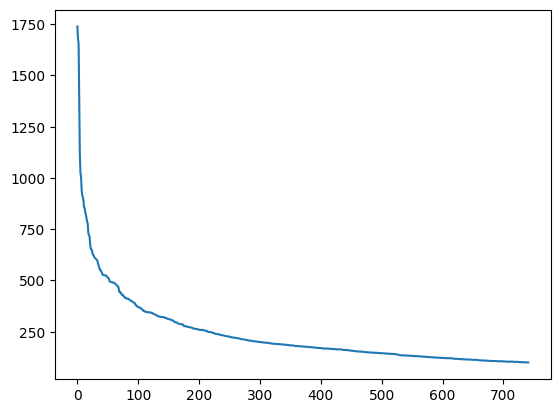

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(df['cohort_id'].nunique()), df['cohort_id'].value_counts().values)

In [14]:
df.head()

,sector,nss_region,max_income_from,hoh_religion,family_size,has_child_elderly,cohort_id
hhid,,,,,,,
46626302,rural,13,self-employment,Islam,large,True,81
46626303,rural,13,self-employment,Islam,large,True,81
46626304,rural,13,self-employment,Islam,large,True,81
46626305,rural,13,self-employment,Islam,large,True,81
46626307,rural,13,self-employment,Islam,nuclear,True,79


In [15]:
df.to_parquet('data/hh-cohorts.parquet')